<a href="https://colab.research.google.com/github/vinceecws/Algonauts2021-NMA/blob/main/Algonauts2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Working directory will be primarily in /content in case you get lost.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# You need to change the code in this next block

In [ ]:
%cd drive/MyDrive/Algonauts2021/Algonauts2021_devkit
#Yours will be drive/Shareddrives/Algonauts2021/Algonauts2021_devkit

/content/drive/MyDrive/Algonauts2021/Algonauts2021_devkit


In [ ]:
%%capture 
!pip install nilearn torch torchvision decord opencv-python neurora tqdm shap


In [ ]:
# @title AlgoData Class

from perform_encoding import get_fmri
from neurora import rdm_cal, rdm_corr
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform, pdist
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings

class AlgoData:
    '''
    A class that provide utility functions for statistical analysis of the mini-track of the Algonauts 2021 dataset.

    Class attributes:
    subjects (List of str): List containing the subject names in the Algonauts 2021 dataset.
    rois (List of str): List containing the 9 RoI (Region of Interest) names in the mini-track of the Algonauts 2021 dataset.
    categories (List of str): List containing the ground-truth annotation categories.
    
    Instance attributes:
    data (dict of dict of numpy.ndarray): A nested dict with top-level key corresponding to one of AlgoData.subjects and sub-level key 
        corresponding to one of AlgoData.rois. Each (top-level key, sub-level key) combination points to the voxel data of the
        (subject, roi) combination.
    data (dict of dict of numpy.ndarray): PCA of self.data. Depending on num_components passed to init_data_pca(), data shapes
        might be uniform/non-uniform. Read the num_components param in init_data_pca() for a more detailed explanation.

    Methods:
    init_data: Initialize data. Optionally, with row indices corresponding to the video samples in the dataset;
        with specific subject(s);
        with specific RoI(s).
    _computeRDM: Base method to compute RDM given a voxel data array.
    _computeRDM_alt: Alternative method to compute RDM given a voxel data array using utilities in scipy.spatial.distance.
    computeSubjectRDM: Computes RDM of all available RoI in the current instance given a single subject.
    computeRegionRDM: Computes RDM of all available subjects in the current instance given a single RoI.
    computePearsonRSA: Computes the RSA matrix of multiple RDMs using the Pearson's R metric.
        
    '''

    subjects = ['sub01', 'sub02', 'sub03', 'sub04', 'sub05', 'sub06', 'sub07', 'sub08', 'sub09', 'sub10']
    rois = ['EBA', 'FFA', 'LOC', 'PPA', 'STS', 'V1', 'V2', 'V3', 'V4']
    categories = ['Body', 'Face', 'Object', 'Scene']

    def __init__(self, data_dir):
        self.data_dir = data_dir
        self._data = {}
    
    @property
    def data(self):
        assert len(self._data.keys()) > 0, "Data is not initialized. Run init_data() first."
        return self._data 

    @property
    def data_pca(self):
        assert len(self._data_pca.keys()) > 0, "PCA data is not initialized. Run init_data_pca() first."
        return self._data_pca
    
    def init_data(self, idx=None, subject=None, roi=None):
        '''Method to initialize the current instance data, optionally with specific video_sample row indices,
        subject(s) in AlgoData.subjects, RoI(s) in AlgoData.rois.

        Args:
        idx (List): Row indices with which to subsample voxel data with. 
            If None, use all samples. Default: None.
        subject (List or str): Subject(s) to include in the data. If str, then assumed to be one subject. 
            If None, use all subjects. Default: None.
        roi (List or str): RoI(s) to include in the data. If str, then assumed to be one RoI. 
            If None, use all RoIs. Default: None.

        Returns:
        None

        '''
        if (isinstance(subject, list) and len(subject) == 0) or (isinstance(roi, list) and len(roi) == 0):
            raise ValueError('subject or roi argument that is [] leads to unproducible data')

        data = {}
        if subject is None: #Fetch all subjects
            subject = AlgoData.subjects
        elif isinstance(subject, str):
            subject = [subject]
        elif isinstance(subject, list):
            pass
        else:
            raise ValueError('subject must be one of List, String or None')

        if roi is None: #Fetch all RoI
            roi = AlgoData.rois
        elif isinstance(roi, str):
            roi = [roi]
        elif isinstance(roi, list):
            pass
        else:
            raise ValueError('roi must be one of List, String or None')

        for s in subject:
            sub_data = {}
            for r in roi:
                tmp = get_fmri(os.path.join(self.data_dir, s), r)
                sub_data[r] = tmp if idx is None else tmp[idx]

            data[s] = sub_data
        
        self._data = data
    
    def init_data_pca(self, num_components=None):
        '''Method to initialize the current instance PCA transformed data.

        Args:
        num_components (int): The number of features (top K principal-components) to be included in the data.
            If None, num_components = min_features (i.e. min(N_VOXELS for data in self.data)). Default: None.
            **Note: If num_components > min_features, PCA will be computed on min(num_components, N_VOXELS) for each data.
                This will result in inconsistencies in N_VOXELS for each PCA transformed data.

        '''

        assert len(self._data.keys()) > 0, "Data is not initialized. Run init_data() before performing any operations"

        min_features = float('inf')

        for s in self._data.values():
            for r in s.values():
                if (r.shape[1] < min_features):
                    min_features = r.shape[1]

        min_features = int(min_features)

        if num_components is not None: 
            if num_components > min_features:
                warnings.warn("Given num_components of {} given > minimum features in the dataset. Data might not have uniform number of features.")
            else:
                pass
        else:
            num_components = min_features
        
        data = {}

        for key_s, s in self._data.items():
            sub_data = {}
            for key_r, r in s.items():
                sub_data[key_r] = self._computePCA(r, min(r.shape[1], num_components))

            data[key_s] = sub_data

        self._data_pca = data
    
    def _computeRDM(self, data):
        '''Base function to compute RDM given a voxel array.

        Args:
        data (numpy.ndarray): An array of shape (N_SAMPLES x N_VOXELS).

        Returns:
        res (numpy.ndarray): The RDM of the given voxel array, having the shape (N_SAMPLES x N_SAMPLES).

        '''

        data_3d = data.reshape((data.shape[0], 1, 1, 1, data.shape[1]))
        roi_mask = np.ones((1, 1, data.shape[1]))
        res = rdm_cal.fmriRDM_roi(data_3d, roi_mask, sub_opt=0)

        return res

    def _computeRDM_alt(self, data):
        '''Alternative method to compute RDM given a voxel array.
        This function is used to cross-check the validity of _computeRDM()'s results, implemented using scipy.spatial.distance.

        Args:
        data (numpy.ndarray): An array of shape (N_SAMPLES x N_VOXELS).

        Returns:
        res (numpy.ndarray): The RDM of the given voxel array, having the shape (N_SAMPLES x N_SAMPLES).

        '''

        return squareform(pdist(data))

    def _computePCA(self, data, num_components):
        '''Computes the PCA of the data given a voxel array.

        Args:
        data (array-like): An array of shape (N_SAMPLES x N_VOXELS).
        num_components (int): The number of top principal components to include in the transformed data. Must be <= N_VOXELS.

        Returns:
        res (array-like): The PCA with  of the given voxel array, having the shape (N_SAMPLES x N_SAMPLES).

        '''
        data = np.array(data)
        assert num_components > 0 and num_components <= data.shape[1], "num_components must be between 1 and N_VOXELS"

        return PCA(n_components=num_components).fit_transform(data)
    
    
    def computeSubjectRDM(self, subj, use_alt=False):
        '''Computes RDM of all available regions given a single subject.

        Args:
        subj (str): A String that is one of self._data.keys(), which are the available subject(s) in this AlgoData instance.
        use_alt (boolean): If True, uses _computeRDM_alt() to compute the RDM, else uses _computeRDM(). Default: False

        Returns:
        res (dict of numpy.ndarray): A dict containing the RDM of each corresponding roi voxel array of the given subj,
            each having the shape (N_SAMPLES x N_SAMPLES). 

        '''

        assert len(self._data.keys()) > 0, "Data is not initialized. Run init_data() before performing any operations"
        assert subj in self._data.keys(), "subj={} does not exist as a key in the data. Run init_data() again to include {}".format(subj, subj)

        res = dict()
        for roi in sorted(self._data[subj].keys()):
            if use_alt:
                res[roi] = self._computeRDM_alt(self._data[subj][roi])
            else:
                res[roi] = self._computeRDM(self._data[subj][roi])

        return res

    def computeRegionRDM(self, roi, use_alt=False):
        '''Computes RDM of all available subjects given a single Region of Interest (ROI).

        Args:
        roi (str): A String that is one of self._data[list(self._data.keys())[0]].keys(), which are the available RoI(s) in this AlgoData instance.
        use_alt (boolean): If True, uses _computeRDM_alt() to compute the RDM, else uses _computeRDM(). Default: False

        Returns:
        res (dict of numpy.ndarray): A dict containing the RDM of each corresponding subject voxel array of the given roi,
            each having the shape (N_SAMPLES x N_SAMPLES). 

        '''
        assert len(self._data.keys()) > 0, "Data is not initialized. Run init_data() before performing any operations"
        assert roi in self._data[list(self._data.keys())[0]].keys(), "roi={} does not exist as a key in the data. Run init_data() again to include {}".format(roi, roi)

        res = dict()
        for subj in sorted(self._data.keys()):
            if use_alt:
                res[subj] = self._computeRDM_alt(self._data[subj][roi])
            else:
                res[subj] = self._computeRDM(self._data[subj][roi])

        return res

    def computePearsonRSA(self, rdm_dict, plot_res=False):
        '''Computes the RSA among all RDM's in given dict using Pearson's R Correlation.

        Args:
        rdm_dict (dict of numpy.ndarray): A dict where values are the RDM of the keys.
        plot_res (boolean): If True, plots the RSA matrix. Default: False

        Returns:
        corr (numpy.ndarray): Array where each i, j is the pairwise Pearson's R Correlation of the RDMs
        pval (numpy.ndarray): Array where each i, j is the p-value of the correlation of the RDMs

        '''
        N = len(rdm_dict.keys())
        corr = np.zeros((N, N))
        pval = np.zeros((N, N))

        for i, key_i in enumerate(rdm_dict.keys()):
            for j, key_j in enumerate(rdm_dict.keys()):
                if i == j:
                    res = [1.0, 0.0]
                else:
                    res = rdm_corr.rdm_correlation_pearson(rdm_dict[key_i],rdm_dict[key_j])

                corr[i, j], pval[i, j] = res

        if plot_res:
            fig = plt.figure(figsize=(12,8), dpi= 100)
            ax = fig.add_subplot(121)
            cax = ax.matshow(corr, interpolation='nearest')
            fig.colorbar(cax)
            plt.title('RSA')
            ax.set_xticks(np.arange(N))
            ax.set_yticks(np.arange(N))
            ax.set_xticklabels(list(rdm_dict.keys()))
            ax.set_yticklabels(list(rdm_dict.keys()))

            ax = fig.add_subplot(122)
            cax = ax.matshow(pval, interpolation='nearest')
            fig.colorbar(cax)
            plt.title('p-values')
            ax.set_xticks(np.arange(N))
            ax.set_yticks(np.arange(N))
            ax.set_xticklabels(list(rdm_dict.keys()))
            ax.set_yticklabels(list(rdm_dict.keys()))
            plt.show()

        return corr, pval

    


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [ ]:
# @title Annotations Class

import os
import numpy as np
import pandas as pd
from collections import namedtuple

class Annotations:
    '''
    Annotations class that provide utility functions to filter and manipulate rows in the annotation data.

    Class attributes:
      annotators (dict of NamedTuple): Dict containing the start-index & end-index corresponding to the annotated rows for each annotator key.
    
    Instance attributes:
      annotations (pandas.DataFrame): The DataFrame object of the original annotations.csv or any filtered instance.
      cols (List): The column keys for the annotations DataFrame.
      row_idxs (List): The row indices which exist in the annotations DataFrame of the current instance.

    Methods:
      _get: The base method to return a new sub-sampled Annotations instance given row indices.
      filterByIndex: Basic wrapper for _get, returns a new sub-sampled Annotations instance given row indices.
      filterByAnnotator: Filters by returning a new instance with only samples corresponding to the given annotator.
      filterByCategory: Filters by returning a new instance with only samples corresponding to the given category, value pair.
      unionWith: Returns a new instance by union-merging the current instance with another given instance.
      intersectWith: Returns a new instance by intersect-merging the current instance with another given instance.
      
    '''

    index = namedtuple('Index', ['start', 'end'])
    annotators = {
        'saloni': index(start=0, end=274),
        'abdur-rahman': index(start=275, end=550),
        'tilek': index(start=551, end=825),
        'vincent': index(start=826, end=1101)
    }

    def __init__(self, annotations):
        '''Constructor

        Args:
        annotations (pandas.DataFrame): The DataFrame object of the original annotations.csv or any filtered instance. 

        Returns
        None

        '''

        if isinstance(annotations, pd.DataFrame):
            self._annotations = annotations
        else:
            self._annotations = pd.read_csv(annotations)
    
        self._cols = self._annotations.columns.tolist()
        self._row_idxs = self._annotations.index.tolist()

    @property
    def annotations(self):
        return self._annotations

    @property
    def cols(self):
        return self._cols
    
    @property
    def row_idxs(self):
        return self._row_idxs


    def _get(self, idx):
        '''Base method to get only corresponding rows given in idx (if they exist).
        Any indices given in idx that do not exist in the DataFrame is simply ignored.

        Args:
        idx (1D List): Row indices with which to subsample the DataFrame. 

        Returns
        Annotations : A new filtered instance of Annotations

        '''

        idx = list(set(idx) & set(self._annotations.index.tolist())) #Get common indices
        return Annotations(self._annotations.loc[idx].sort_index())

    def filterByIndex(self, idx):
        '''Basic wrapper for _get(). 
            Method to filter data by row indices. 
            Rows with index in idx will be included.

            Args:
            idx (1D List): Row indices with which to subsample the DataFrame.

            Returns
            Annotations : A new index-filtered instance of Annotations derived from the current instance.

        '''

        assert isinstance(idx, list) or isinstance(idx, int), "idx must be a List or Int"
        return self._get(idx if isinstance(idx, list) else [idx])

    def filterByAnnotator(self, annotator):
        '''Method to filter data by annotator. 
            List of annotators is in Annotations.annotators.

            Args:
            annotator (str): The corresponding key of the annotator in Annotations.annotators.

            Returns
            Annotations : A new annotator-filtered instance of Annotations derived from the current instance.

        '''

        assert annotator in Annotations.annotators.keys(), "annotator must be one of {}".format(Annotations.annotators.keys())
        idxs = Annotations.annotators[annotator]
        return self._get(range(idxs.start, idxs.end + 1))

    def filterByCategory(self, category, value):
        '''Method to filter data by annotation category and their corresponding value.

        Args:
        category (str): The corresponding key of the column in self._cols.
        value (boolean): The desired-value in the category for each row.

        Returns
        Annotations : A new category-value-filtered instance of Annotations derived from the current instance.

        '''

        assert category in self._cols, "category must be one of {}".format(self._cols)
        idxs = self._annotations.index[self._annotations[category] == value].tolist()
        return self._get(idxs)
  
    def unionWith(self, annotation):
        '''Method to merge two Annotations with a Union operator.

        Args:
        annotation (Annotations): Another instance with which to union-merge this instance with.

        Returns
        Annotations : A new union-merged instance of Annotations derived from the current instance and the given instance.

        '''
        return Annotations(pd.concat([self._annotations, annotation.annotations]).sort_index())

    def intersectWith(self, annotation):
        '''Method to merge two Annotations with an Intersect operator.

        Args:
        annotation (Annotations): Another instance with which to intersect-merge this instance with.

        Returns
        Annotations : A new intersect-merged instance of Annotations derived from the current instance and the given instance.

        '''
        idxs = self._annotations.index.intersection(annotation.annotations.index)
        return self._get(idxs)

In [ ]:
# @title Plotting & Training/Optimization Functions
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.base import ClassifierMixin
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from tqdm import tqdm
from scipy.special import comb
import itertools

def plot_sub_score_mat(score_mat):
    '''Method to plot a subject's (category, RoI)-wise classification scores, confusion-matrix style.

    Args:
      score_mat (numpy.ndarray): A N_CATEGORY x N_ROI array, where each cell is the classification score of the (category, RoI) pair.

    '''

    fig = plt.figure(figsize=(15,15), dpi=100)
    for i, sub in enumerate(subs):
        scoremat = score_mat[sub]
        ax = fig.add_subplot(3, 4, i + 1)
        cax = ax.matshow(scoremat, interpolation='nearest')
        fig.colorbar(cax)

        ax.title.set_text(sub)
        ax.set_xticklabels(['']+ category)
        ax.set_yticklabels(['']+ rois)

def plot_data_distribution(annotations: Annotations, category: str):
    '''Plots the distribution of labels of a category.

    Args:
      annotations (Annotations): An instance of Annotations.
      category (str): The category to be plotted.

    '''
    assert category in AlgoData.categories, "Invalid category selected, must be one of {}".format(AlgoData.categories)

    data = annotations.annotations[category].to_numpy().astype(int)
    num_categories = np.unique(data).size

    fig = plt.figure(figsize=(8, 8), dpi=100)
    ax = fig.add_subplot(111)
    ax.title.set_text("Distribution of data for the {} category".format(category))
    ax.set_xticks(list(range(num_categories)))
    ax.set_xticklabels(list(range(num_categories)))

    plt.hist(data, bins=num_categories)

def plot_rank_roi_importance(scores: list, n_top_scores: int=50):
    '''Plots the distribution of labels of a category.

    Args:
      scores (dict): The dict of scores as returned by optimize_SingleSubj_BestRegions_SingleCat()
      n_top_scores (int): The top N scores to be considered in the plot.

    '''

    hist = {}
    for i in range(n_top_scores):
        for j in scores[i][0]:
            if j in hist:
                hist[j] += 1
            else:
                hist[j] = 0

    count = [(key, hist[key]) for key in hist.keys()]
    count.sort(key=lambda el: el[1], reverse=True)

    labels, bins = list(zip(*count))

    plt.bar(list(range(len(count))), bins, tick_label=labels)
    plt.title("RoI Importance Ranked By Occurence In The Top {} Scores".format(n_top_scores))
    plt.show()

def plot_roi_score_correlation(scores: list):
    '''Plots the score correlation of RoI(s) given scores from optimize_SingleSubj_BestRegions_SingleCat()

    Args:
      scores (dict): The dict of scores as returned by optimize_SingleSubj_BestRegions_SingleCat()

    '''

    values = {}
    for rois, score in scores:
        for region in rois:
            if region in values:
                values[region].append(score)
            else:
                values[region] = []
    
    keys = list(values.keys())

    corr = np.zeros((len(keys), len(keys)))
    p = np.zeros((len(keys), len(keys)))

    for i, key_i in enumerate(keys):
        for j, key_j in enumerate(keys):
            corr[i][j], p[i][j] = (1.0, 0.0) if i == j else pearsonr(values[key_i], values[key_j])

    return corr, p

def optimize_SingleSubj_BestRegions_SingleCat(algodata: AlgoData, annotations: Annotations, classifier: ClassifierMixin, 
                                              category: str, subject: str, rois: list=None, metric=None, R=None, cross_validation_fold: int=None, test_size: float=0.3):
  
    '''Train a classifier model on a single subject, a single category, while iterating through the given categories to find the
    combination producing the best model, using a given metric to rank model performances.
    The strategy used for regions selection is the simple exhaustive search strategy, where every possible combination of all given regions are considered.
    The search space consist of the set of NcN + Nc(N-1) + Nc(N-2) + ... + Nc1 = 2^N. 
    For this project, the search space remains small enough, at only 2^(9) - 1 = 511 maximum possible combinations of regions, which makes this thorough strategy feasible.

    Args:
    algodata (AlgoData): The AlgoData instance containing the data subset.
    annotations (Annotations): The Annotations instance containing the labels.
    classifier (ClassifierMixin): An sklearn ClassifierMixin instance used to fit and predict the data.
    category (str): The category that the classifier is to be trained on.
    subject (str): The subject of the data that the classifier is to be trained on.
    rois (list): The list of RoI(s) (Regions of Interest) to include as features in the model. 
        All features are concatenated as k-dimensional vector. If None, all RoIs are considered.
    metric (Callable[ClassifierMixin, array-like of (n_samples, n_features), array-like array-like of (n_samples,)], double]): 
        The function that takes in a model, a test set input X, the corresponding target y,
        evaluate their performances on a metric, returns the score. If none, models are evaluated using classification accuracy.
        **Note: Model performance will be ranked in order of larger-value-first. Metrics that optimize for lower-values should return an inverse score. (i.e. 1 / score)
    R (int): The maximum number of elements in a given combination NcR. If None, then 
    cross_validation_fold (int): The parameter 'k' in a k-Fold Cross Validation Strategy. The best-scoring classifier
        from the cross-validation is selected to predict the testing data. 
        If None, cross-validation is skipped. All training data will be used to fit the model.
    test_size (float): The fraction of the original dataset to be allocated for testing.

    Returns:
    scores (list of Tuple): The score-sorted list, where each element is a tuple of (list of RoIs used in the model, metric score of the model)

    '''
    scores = []

    if rois is None:
        rois = AlgoData.rois

    if metric is None:
        metric = lambda model, X, y: model.score(X, y)

    if R is None:
        R = len(rois)

    with tqdm(total=sum([comb(len(rois), i, exact=True) for i in range(1, R + 1)])) as pbar:
        for r in range(1, R + 1):
            for roi_subset in itertools.combinations(rois, r):
                clf, _, _, X_test, _, y_test = train_SingleSubj_MultiRegion_SingleCat(algodata, annotations, classifier, category, subject, rois=roi_subset,
                                                      cross_validation_fold=cross_validation_fold, test_size=test_size, plot_res=False, return_data=True)
                
                if clf is None:
                    continue
                    
                scores.append((roi_subset, metric(clf, X_test, y_test)))

                pbar.update(1)

    scores.sort(key=lambda el: el[1], reverse=True)

    return scores

def train_SingleSubj_MultiRegion_SingleCat(algodata: AlgoData, annotations: Annotations, classifier: ClassifierMixin, 
                                           category: str, subject: str, rois: list=None, cross_validation_fold: int=None, test_size: float=0.3, plot_res=True, return_data=False):
  
    '''Train a classifier model on a single subject, multiple regions on a single category.

    Args:
    algodata (AlgoData): The AlgoData instance containing the data subset.
    annotations (Annotations): The Annotations instance containing the labels.
    classifier (ClassifierMixin): An sklearn ClassifierMixin instance used to fit and predict the data.
    category (str): The category that the classifier is to be trained on.
    subject (str): The subject of the data that the classifier is to be trained on.
    rois (list): The list of RoI(s) (Regions of Interest) to include as features in the model. 
        All features are concatenated as k-dimensional vector. If None, all RoIs are used.
    cross_validation_fold (int): The parameter 'k' in a k-Fold Cross Validation Strategy. The best-scoring classifier
        from the cross-validation is selected to predict the testing data. 
        If None, cross-validation is skipped. All training data will be used to fit the model.
    test_size (float): The fraction of the original dataset to be allocated for testing.
    plot_res (bool): If True, prints performance report & plots model performance. 
    return_data (bool): If True, returns the training and testing data.

    Returns:
    clf (ClassifierMixin): The fitted classifier.
    cv_res (dict or None): The cross-validation performance of the models in each of the k-Fold(s).
        None if cross_validation_fold=None

    '''
    assert category in AlgoData.categories, "Invalid category selected, must be one of {}".format(AlgoData.categories)
    assert subject in AlgoData.subjects, "Invalid subject selected, must be one of {}".format(AlgoData.subjects)
    assert rois is None or set(rois).issubset(AlgoData.rois), "Invalid RoI selected, must be one or more of {}".format(AlgoData.rois)

    if rois is None:
        rois = AlgoData.rois

    X = np.concatenate([algodata.data[subject][roi] for roi in rois], axis=1)
    y = annotations.annotations[category].to_numpy().astype(int)

    X = StandardScaler().fit_transform(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    clf = None
    if cross_validation_fold is not None:
        cv_res = cross_validate(classifier, X_train, y_train, cv=cross_validation_fold, return_estimator=True, n_jobs=-1)
        try:
            best_ind = np.nanargmax(cv_res['test_score'])
        except ValueError:
            print("All models failed to converge.")
        else:
            clf = cv_res['estimator'][best_ind] #Select best performing model on CV
    else:
        cv_res = None
        clf = classifier.fit(X_train, y_train)

    try:
        y_pred = clf.predict(X_test)
    except AttributeError:
        print("Model failed to converge.")
        clf = None
    else:
        if plot_res:
            print("Classification report for model trained on single subject, multi-region, single category: \n")
            print("Subject: {}".format(subject))
            print("Region(s): {}".format(rois))
            print("Category: {}\n".format(category))

            print("Training samples (incl. CV, if applicable): {}".format(y_train.size))
            print("Testing samples: {}".format(y_test.size))

            if cross_validation_fold is not None and cross_validation_fold > 0:
                print("Cross-validation: {}-folds".format(cross_validation_fold))

            print('')
            print(classification_report(y_test, y_pred, target_names=['Not' + category, category]))

            disp = plot_confusion_matrix(clf, X_test, y_test, display_labels=['Not' + category, category])
            disp.ax_.set_title("Confusion matrix for model trained on single subject, multi-region, single category")
            plt.show()

    if return_data:
        return clf, cv_res, X_train, X_test, y_train, y_test
    else:
        return clf, cv_res

def optimize_MultiSubj_BestRegions_SingleCat(algodata: AlgoData, annotations: Annotations, classifier: ClassifierMixin, 
                                              category: str, subjects: list=None, rois: list=None, metric=None, R=None, cross_validation_fold: int=None, test_size: float=0.3):
  
    '''Train a classifier model on a multiple subjects, a single category, while iterating through the given categories to find the
    combination producing the best model, using a given metric to rank model performances.
    The strategy used for regions selection is the simple exhaustive search strategy, where every possible combination of all given regions are considered.
    The search space consist of the set of NcN + Nc(N-1) + Nc(N-2) + ... + Nc1 = 2^N. 
    For this project, the search space remains small enough, at only 2^(9) - 1 = 511 maximum possible combinations of regions, which makes this thorough strategy feasible.

    Args:
    algodata (AlgoData): The AlgoData instance containing the data subset.
    annotations (Annotations): The Annotations instance containing the labels.
    classifier (ClassifierMixin): An sklearn ClassifierMixin instance used to fit and predict the data.
    category (str): The category that the classifier is to be trained on.
    subjects (list): The list of subjects of the data that the classifier is to be trained on.
        Each (subject, sample) is treated as an individual sample. Essentially the dataset will have (N_SUBJECTS_SAMPLES, N_VOXELS) samples.
        If None, all subjects are used.
    rois (list): The list of RoI(s) (Regions of Interest) to include as features in the model. 
        All features are concatenated as k-dimensional vector. If None, all RoIs are considered.
    metric (Callable[ClassifierMixin, array-like of (n_samples, n_features), array-like array-like of (n_samples,)], double]): 
        The function that takes in a model, a test set input X, the corresponding target y,
        evaluate their performances on a metric, returns the score. If none, models are evaluated using classification accuracy.
        **Note: Model performance will be ranked in order of larger-value-first. Metrics that optimize for lower-values should return an inverse score. (i.e. 1 / score)
    R (int): The maximum number of elements in a given combination NcR. If None, then 
    cross_validation_fold (int): The parameter 'k' in a k-Fold Cross Validation Strategy. The best-scoring classifier
        from the cross-validation is selected to predict the testing data. 
        If None, cross-validation is skipped. All training data will be used to fit the model.
    test_size (float): The fraction of the original dataset to be allocated for testing.

    Returns:
    scores (list of Tuple): The score-sorted list, where each element is a tuple of (list of RoIs used in the model, metric score of the model)

    '''
    scores = []

    if rois is None:
        rois = AlgoData.rois

    if metric is None:
        metric = lambda model, X, y: model.score(X, y)

    if R is None:
        R = len(rois)

    with tqdm(total=sum([comb(len(rois), i, exact=True) for i in range(1, R + 1)])) as pbar:
        for r in range(1, R + 1):
            for roi_subset in itertools.combinations(rois, r):
                clf, _, _, X_test, _, y_test = train_MultiSubj_MultiRegion_SingleCat(algodata, annotations, classifier, category, subjects=subjects, rois=roi_subset,
                                                      cross_validation_fold=cross_validation_fold, test_size=test_size, plot_res=False, return_data=True)
                
                if clf is None:
                    continue
                    
                scores.append((roi_subset, metric(clf, X_test, y_test)))

                pbar.update(1)

    scores.sort(key=lambda el: el[1], reverse=True)

    return scores

def train_MultiSubj_MultiRegion_SingleCat(algodata: AlgoData, annotations: Annotations, classifier: ClassifierMixin, 
                                           category: str, subjects: list=None, rois: list=None, cross_validation_fold: int=None, test_size: float=0.3, plot_res=True, return_data=False):
  
    '''Train a single classifier model on multiple subjects, multiple regions on a single category with data_pca.
    Assumes cross-subject, cross-region data are uniformly-shaped and treats each (subject, sample) pair as a single sample,
    such that there will be N_SUBJECTS x N_SAMPLES samples.

    Args:
    algodata (AlgoData): The AlgoData instance containing the data subset.
    annotations (Annotations): The Annotations instance containing the labels.
    classifier (ClassifierMixin): An sklearn ClassifierMixin instance used to fit and predict the data.
    category (str): The category that the classifier is to be trained on.
    subjects (list): The list of subjects of the data that the classifier is to be trained on.
        Each (subject, sample) is treated as an individual sample. Essentially the dataset will have (N_SUBJECTS_SAMPLES, N_VOXELS) samples.
        If None, all subjects are used.
    rois (list): The list of RoI(s) (Regions of Interest) to include as features in the model. 
        All features are concatenated as k-dimensional vector. If None, all RoIs are used.
    cross_validation_fold (int): The parameter 'k' in a k-Fold Cross Validation Strategy. The best-scoring classifier
        from the cross-validation is selected to predict the testing data. 
        If None, cross-validation is skipped. All training data will be used to fit the model.
    test_size (float): The fraction of the original dataset to be allocated for testing.
    plot_res (bool): If True, prints performance report & plots model performance. 
    return_data (bool): If True, returns the training and testing data.

    Returns:
    clf (ClassifierMixin): The fitted classifier.
    cv_res (dict or None): The cross-validation performance of the models in each of the k-Fold(s).
        None if cross_validation_fold=None

    '''
    assert category in AlgoData.categories, "Invalid category selected, must be one of {}".format(AlgoData.categories)
    assert subjects is None or set(subjects).issubset(AlgoData.subjects), "Invalid subject selected, must be one of {}".format(AlgoData.subjects)
    assert rois is None or set(rois).issubset(AlgoData.rois), "Invalid RoI selected, must be one or more of {}".format(AlgoData.rois)

    if subjects is None:
        subjects = AlgoData.subjects

    if rois is None:
        rois = AlgoData.rois

    X = np.concatenate([np.concatenate([algodata.data_pca[subject][roi] for roi in rois], axis=1) for subject in subjects], axis=0)
    y = np.tile(annotations.annotations[category].to_numpy().astype(int), len(subjects))

    X = StandardScaler().fit_transform(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    clf = None
    if cross_validation_fold is not None:
        cv_res = cross_validate(classifier, X_train, y_train, cv=cross_validation_fold, return_estimator=True, n_jobs=-1)
        try:
            best_ind = np.nanargmax(cv_res['test_score'])
        except ValueError:
            print("All models failed to converge.")
        else:
            clf = cv_res['estimator'][best_ind] #Select best performing model on CV
    else:
        cv_res = None
        clf = classifier.fit(X_train, y_train)

    try:
        y_pred = clf.predict(X_test)
    except AttributeError:
        print("Model failed to converge.")
        clf = None
    else:
        if plot_res:
            print("Classification report for model trained on multi-subject, multi-region, single category: \n")
            print("Subject(s): {}".format(subjects))
            print("Region(s): {}".format(rois))
            print("Category: {}\n".format(category))

            print("Training samples (incl. CV, if applicable): {}".format(y_train.size))
            print("Testing samples: {}".format(y_test.size))

            if cross_validation_fold is not None and cross_validation_fold > 0:
                print("Cross-validation: {}-folds".format(cross_validation_fold))

            print('')
            print(classification_report(y_test, y_pred, target_names=['Not' + category, category]))

            disp = plot_confusion_matrix(clf, X_test, y_test, display_labels=['Not' + category, category])
            disp.ax_.set_title("Confusion matrix for model trained on multi-subject, multi-region, single category")
            plt.show()

    if return_data:
        return clf, cv_res, X_train, X_test, y_train, y_test
    else:
        return clf, cv_res

In [ ]:
#Establish directories
videos_dir = '../participants_data/AlgonautsVideos268_All_30fpsmax'
fmri_dir = '../participants_data/participants_data_v2021/mini_track'
annotations_dir = '../participants_data/participants_data_v2021/mini_track/annotations.csv'
annotations_new_dir = '../participants_data/participants_data_v2021/mini_track/annotations-OR.csv'


annotations = Annotations(annotations_new_dir)
all_annotations = annotations.filterByIndex(list(range(1000)))

dataset_all = AlgoData(fmri_dir)
dataset_all.init_data(all_annotations.row_idxs)

In [ ]:
dataset_all.init_data_pca(num_components=None)

In [ ]:
# for i in range(50):
#     print(scores[i])

In [ ]:
# clf, _, X_train, X_test, y_train, y_test = train_MultiSubj_MultiRegion_SingleCat(dataset_all, all_annotations, LogisticRegression(max_iter=1000), 'Face', rois=['EBA', 'FFA', 'LOC', 'STS', 'V1', 'V3'], return_data=True)

In [ ]:
import shap
# # compute the SHAP values for the linear model
# background_train = shap.maskers.Independent(X_train, max_samples=100)
# explainer_log_odds = shap.Explainer(model_log_odds, background_train)
# shap_values_log_odds = explainer_log_odds(X_train)

# def model_proba(X):
#     return clf.predict_proba(X)[:,1]
# def model_log_odds(X):
#     p = clf.predict_log_proba(X)
#     return p[:,1] - p[:,0]

# shap.plots.scatter(shap_values_log_odds[:, 67], color="c")
# shap.plots.beeswarm(shap_values_log_odds, max_display=30)

Classification report for model trained on single subject, multi-region, single category: 

Subject: sub01
Region(s): ['EBA', 'FFA', 'LOC', 'STS']
Category: Face

Training samples (incl. CV, if applicable): 700
Testing samples: 300
Cross-validation: 5-folds

              precision    recall  f1-score   support

     NotFace       0.79      0.78      0.78       172
        Face       0.71      0.72      0.71       128

    accuracy                           0.75       300
   macro avg       0.75      0.75      0.75       300
weighted avg       0.75      0.75      0.75       300



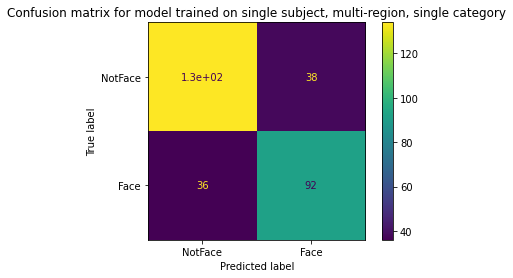

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_single = LogisticRegression(max_iter=1000)
clf_single, _, X_train, X_test, y_train, y_test = train_SingleSubj_MultiRegion_SingleCat(dataset_all, all_annotations, clf_single, 'Face', 'sub01', rois=['EBA', 'FFA', 'LOC', 'STS'], cross_validation_fold=5, return_data=True)

In [ ]:
def model_proba(X):
    return clf_single.predict_proba(X)[:,1]
def model_log_odds(X):
    p = clf_single.predict_log_proba(X)
    return p[:,1] - p[:,0]

background_train = shap.maskers.Independent(X_train, max_samples=100)
explainer_log_odds = shap.Explainer(model_log_odds, background_train)
shap_values_log_odds = explainer_log_odds(X_train)

In [ ]:
shap.plots.scatter(shap_values_log_odds[:, 67], color="c")


In [ ]:
shap.plots.beeswarm(shap_values_log_odds, max_display=30)

In [ ]:
# #Pick a hard sample & plot waterfall
# # Indices: 22, 44, 92 
shap.plots.waterfall(shap_values_log_odds[44], max_display=30)

In [ ]:
shap.plots.bar(shap_values_log_odds)